<a href="https://colab.research.google.com/github/profedaniel86/Series_de_Tiempo/blob/main/1.Intro/Suavizaci%C3%B3n_exponencial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fundamentos de analítica 2 -Aprendizaje Automatico III (clase 1)

## Diego Fernando Agudelo - Daniel Felipe Osorio
## Universidad ICESI
## diegoagudelo30@gmail.com - dfosorio@icesi.edu.co


## **1. Carga de paquetes**

In [ ]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error


Este documento presenta una breve introducción a la construcción de objetos de series de tiempo y el cálculo de pronósticos con modelos de suavización.

Para este ejercicio emplearemos la información disponible en el archivo datosEmpleo.xlsx. En ese archivo econtrarán la tasa de desempleo mensual de las 13 principales ciudades en Colombia (TD_13ciudades). El archivo también contiene series mensuales para las 13 principales ciudades de Colombia el número de ocupados en miles de personas (Ocupados), los desocupados (Desocupados) y los inactivos (Inactivos).

## **2. Carga de datos**

Nuestra primera tarea será leer el archivo de Excel. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [2]:
data = pd.read_excel("https://raw.githubusercontent.com/profedaniel86/Series_de_Tiempo/refs/heads/main/1.Intro/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


En este caso los datos fueron leídos como un data frame y adicionalmente la columna "mes" fue seleccionada como indice, con el dataframe de esta forma sera más facil trabajar las series de tiempo.

A continuación se gráfica la tasa de desempleo.



(222, 4)


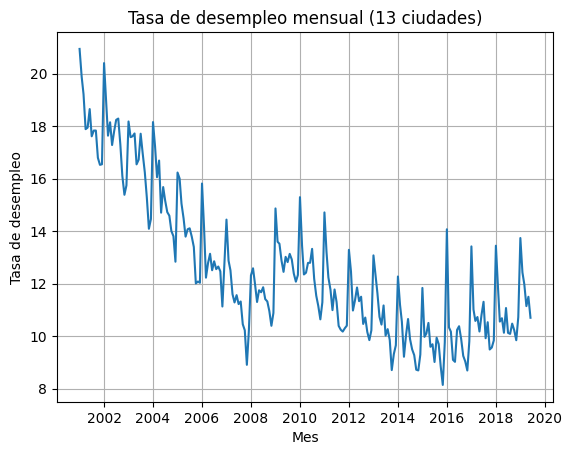

In [3]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Tasa de desempleo mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Tasa de desempleo")
plt.plot(data[["TD_13ciudades"]])
plt.grid()
plt.show()

## **3. Encontrando los componentes de una serie de tiempo**

En algunas ocasiones puede ser útil empezar nuestro análisis descomponiendo la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**. Una forma de hacer esto es empleando la función seasonal_decompose.

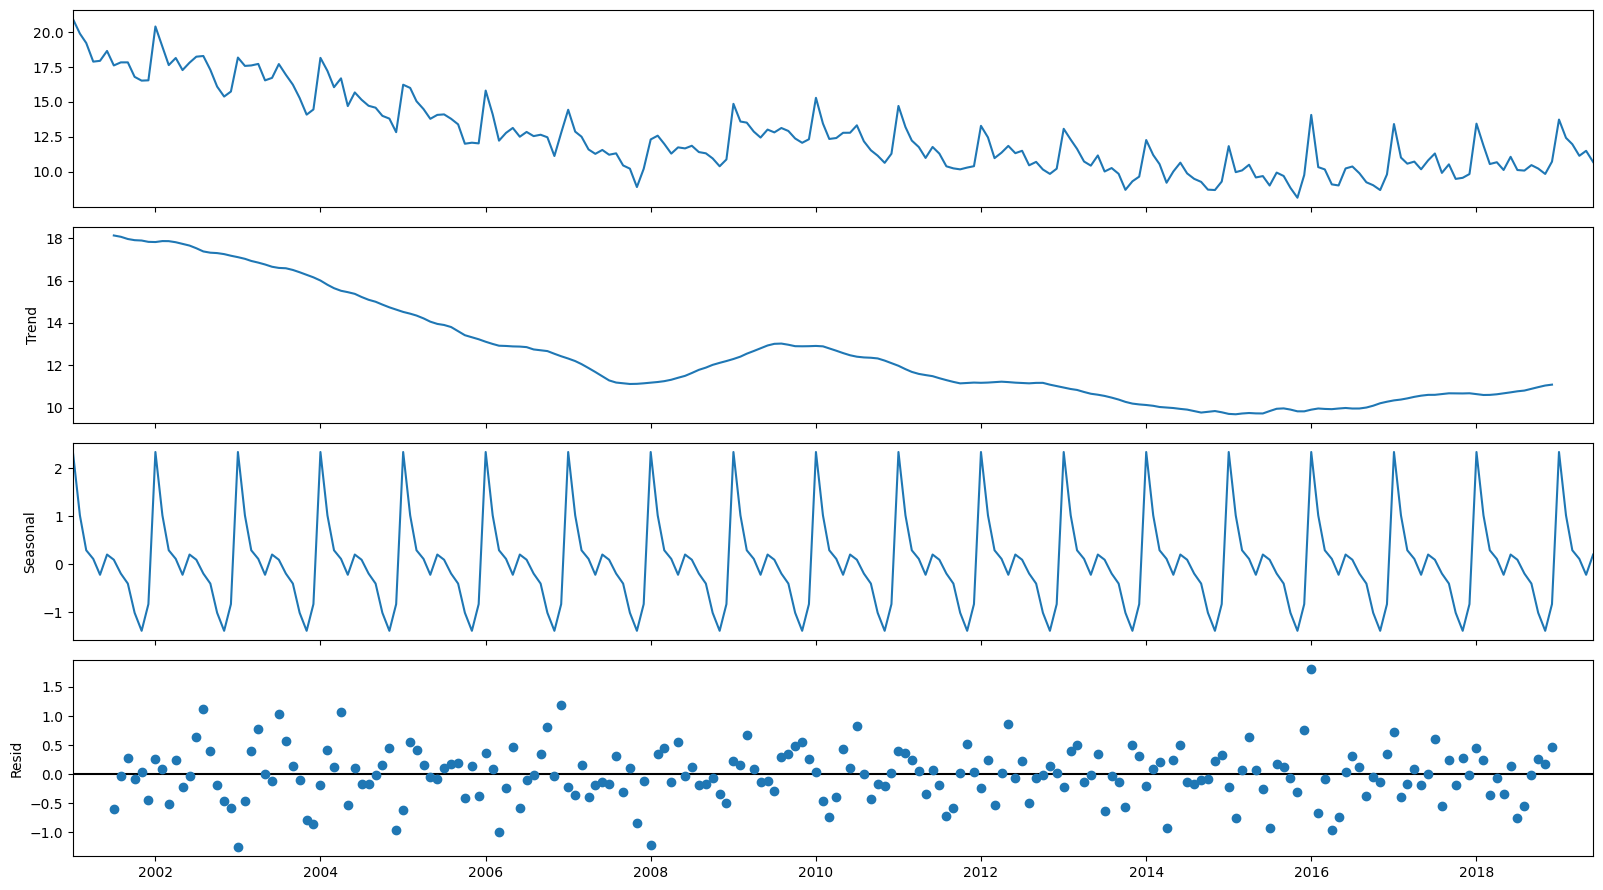

In [4]:
td_componentes = seasonal_decompose(data[["TD_13ciudades"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Asi se extrae cada elemento de la descomposición de la serie.

In [5]:
td_componentes.seasonal
#td_componentes.trend
#td_componentes.resid

mes
2001-01-01    2.337888
2001-02-01    1.017106
2001-03-01    0.290193
2001-04-01    0.110715
2001-05-01   -0.220208
                ...   
2019-02-01    1.017106
2019-03-01    0.290193
2019-04-01    0.110715
2019-05-01   -0.220208
2019-06-01    0.201178
Name: seasonal, Length: 222, dtype: float64

Podemos observar el componente estacional marcado en la serie, una tendencia no lineal de los datos y la parte aleatoria.

Es importante mencionar que esta descomposición se emplea solo como referencia para iniciar el análisis.

Antes de entrar a trabajar con los métodos de suavizamiento, vale la pena anotar que una forma sencilla y rápida para quitar el componente estacional (desestacionalizar) es restarle a la serie el componente estacional encontrado en la descomposición. Es decir,

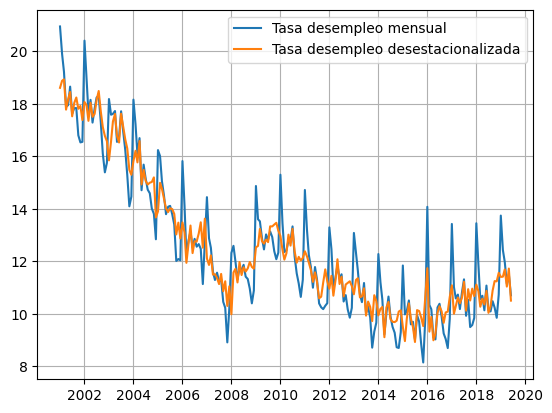

In [6]:
td_desestacionalizada = data["TD_13ciudades"]-td_componentes.seasonal

plt.plot(data[["TD_13ciudades"]],label="Tasa desempleo mensual")
plt.plot(td_desestacionalizada,label="Tasa desempleo desestacionalizada")
plt.legend()
plt.grid()
plt.show()


## **4. Pronosticando metodos de suavización**

Antes de continuar es importante guardar una parte de la muestra para evaluar el comportamiento de los modelos por fuera de muestra (out-of-sample). Guardemos un año de datos.

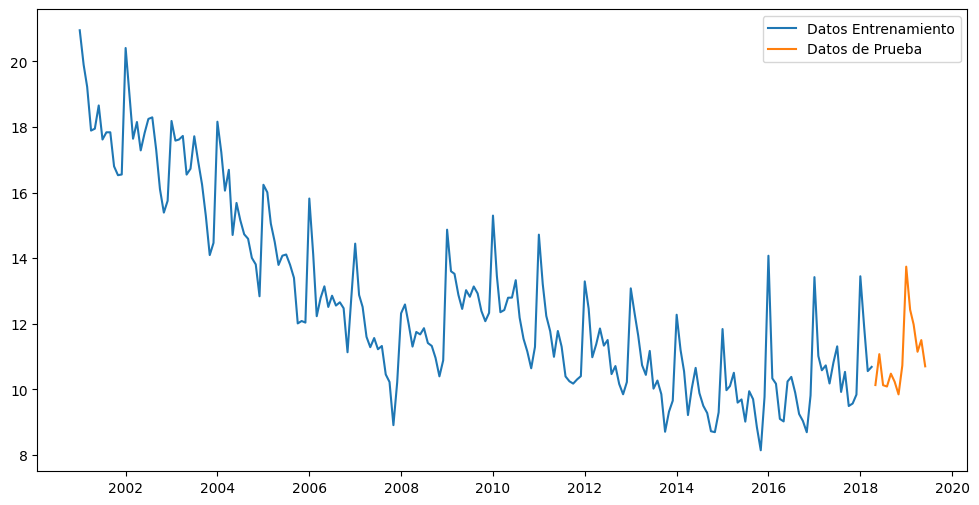

In [7]:
train_len = 208
train_td = data[["TD_13ciudades"]][:train_len]
test_td = data[["TD_13ciudades"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

In [8]:
train_td

,TD_13ciudades
mes,
2001-01-01,20.946380
2001-02-01,19.894213
2001-03-01,19.221565
2001-04-01,17.888575
2001-05-01,17.945654
...,...
2017-12-01,9.837395
2018-01-01,13.446245
2018-02-01,11.874973


In [9]:
test_td

,TD_13ciudades
mes,
2018-05-01,10.129211
2018-06-01,11.071347
2018-07-01,10.125100
2018-08-01,10.085244
2018-09-01,10.476567
2018-10-01,10.230811
2018-11-01,9.844539
2018-12-01,10.725865
2019-01-01,13.739328


### **4.1 Promedio movil**

El promedio móvil está dado por:

$$ F_{t + 1}=\frac{Y_{t} + Y_{t-1} + Y_{t-(k-1)} }{ k} $$

El método de los promedios móviles utiliza el promedio de los $k$
valores de datos más recientes en la serie de tiempo como el
pronóstico para el siguiente periodo.

El término móvil indica que, mientras se dispone de una nueva
observación para la serie de tiempo, reemplaza a la observación más
antigua de la ecuación anterior y se calcula un promedio nuevo.
Como resultado, el promedio cambiará, o se moverá, conforme surjan
nuevas observaciones.

$Y_{t}$ = Observación en el período t

$F_{t}$ = Pronóstico en el período t

In [10]:
## Considerando el dato actual
ma_2= train_td.rolling(2,min_periods=2).mean()
ma_3= train_td.rolling(3,min_periods=2).mean()
ma_4= train_td.rolling(4,min_periods=2).mean()
ma_5= train_td.rolling(5,min_periods=2).mean()

In [11]:
## Sin considerar el dato actual
ma_2= train_td.shift().rolling(2,min_periods=2).mean()
ma_3= train_td.shift().rolling(3,min_periods=2).mean()
ma_4= train_td.shift().rolling(4,min_periods=2).mean()
ma_5= train_td.shift().rolling(5,min_periods=2).mean()


In [12]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [13]:
ma_2_f= fore_ma(train_td,2,14)
ma_3_f= fore_ma(train_td,3,14)
ma_4_f= fore_ma(train_td,4,14)
ma_5_f= fore_ma(train_td,5,14)

In [14]:
test_td

,TD_13ciudades
mes,
2018-05-01,10.129211
2018-06-01,11.071347
2018-07-01,10.125100
2018-08-01,10.085244
2018-09-01,10.476567
2018-10-01,10.230811
2018-11-01,9.844539
2018-12-01,10.725865
2019-01-01,13.739328


In [15]:
ma_2_f

,TD_13ciudades
mes,
2018-05-01,10.618803
2018-06-01,10.651004
2018-07-01,10.634904
2018-08-01,10.642954
2018-09-01,10.638929
2018-10-01,10.640941
2018-11-01,10.639935
2018-12-01,10.640438
2019-01-01,10.640187


In [16]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_td,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_td,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_td,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_td,ma_5_f ))

In [17]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

1.1147962992873541 1.079289141194038 1.0913829514823736 1.079379141938296


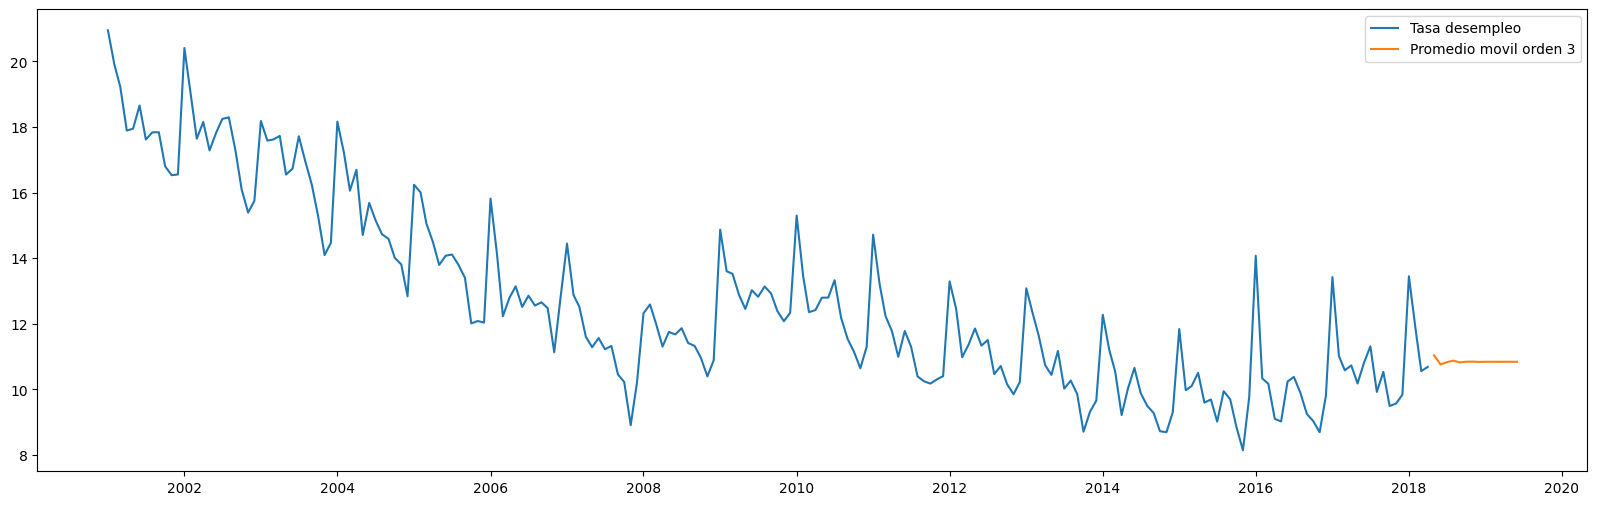

In [18]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Tasa desempleo")
plt.plot(ma_3_f,label="Promedio movil orden 3")
plt.legend()
plt.show()

### **4.2 Suavizacion Exponencial Simple**

In [19]:
# Build model.
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="add")#,trend="add",seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(14)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

            Point_forecast  lower_95   upper_95
2018-05-01       10.959788  8.650409  13.269166
2018-06-01       10.959788  8.505554  13.414021
2018-07-01       10.959788  8.368785  13.550791
2018-08-01       10.959788  8.238882  13.680694
2018-09-01       10.959788  8.114904  13.804671
2018-10-01       10.959788  7.996109  13.923467
2018-11-01       10.959788  7.881894  14.037681
2018-12-01       10.959788  7.771769  14.147806
2019-01-01       10.959788  7.665324  14.254252
2019-02-01       10.959788  7.562211  14.357365
2019-03-01       10.959788  7.462137  14.457439
2019-04-01       10.959788  7.364848  14.554728
2019-05-01       10.959788  7.270123  14.649453
2019-06-01       10.959788  7.177770  14.741806


c:\Personal\Sebas\Universidades\ICESI\Maestrias\InteligenciaArtificialAplicada\Aprendizaje Automatico III\Notebooks\env-AA3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


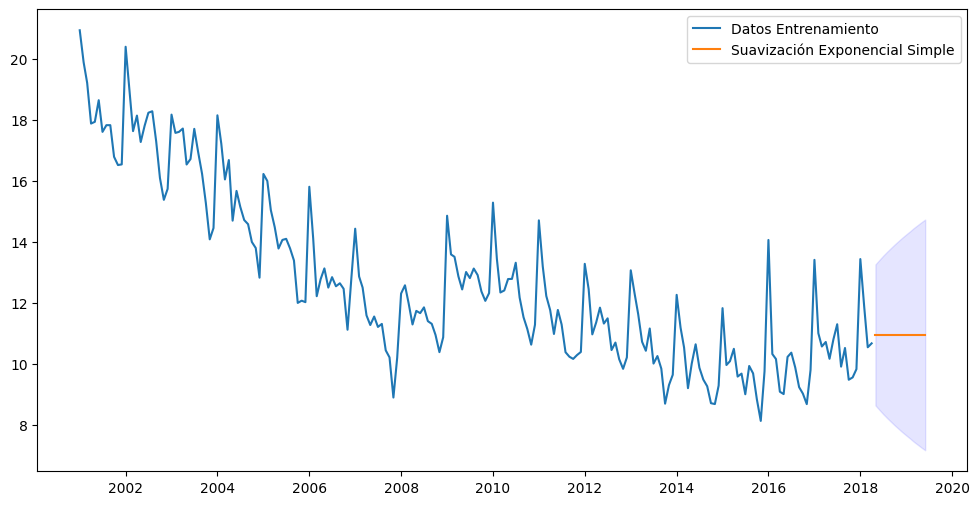

In [20]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

En esta caso el α estimado es 0.3596639.Y el RMSE en la muestra de evaluación es 1.12

In [21]:
ets_result.alpha

np.float64(0.35969957559668314)

In [22]:
rmse = np.sqrt(mean_squared_error(test_td,point_forecast ))
print(rmse)

1.0532673904186352


### **4.3 Suavizacion Exponencial Lineal (Holt)**

In [23]:
# Build model.
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="mul",trend="mul")#,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(14)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

c:\Personal\Sebas\Universidades\ICESI\Maestrias\InteligenciaArtificialAplicada\Aprendizaje Automatico III\Notebooks\env-AA3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast  lower_95   upper_95
2018-05-01       10.660587  8.524511  12.849118
2018-06-01       10.632890  8.538042  12.758360
2018-07-01       10.605265  8.406763  12.716411
2018-08-01       10.577711  8.454628  12.882496
2018-09-01       10.550230  8.376840  12.799741
2018-10-01       10.522819  8.211779  12.766262
2018-11-01       10.495480  8.135225  13.080823
2018-12-01       10.468212  8.312701  12.893792
2019-01-01       10.441014  8.303894  12.903192
2019-02-01       10.413888  8.255299  12.971363
2019-03-01       10.386832  8.240480  12.964057
2019-04-01       10.359846  8.170530  12.852077
2019-05-01       10.332930  8.191900  12.898382
2019-06-01       10.306084  7.852240  12.896643


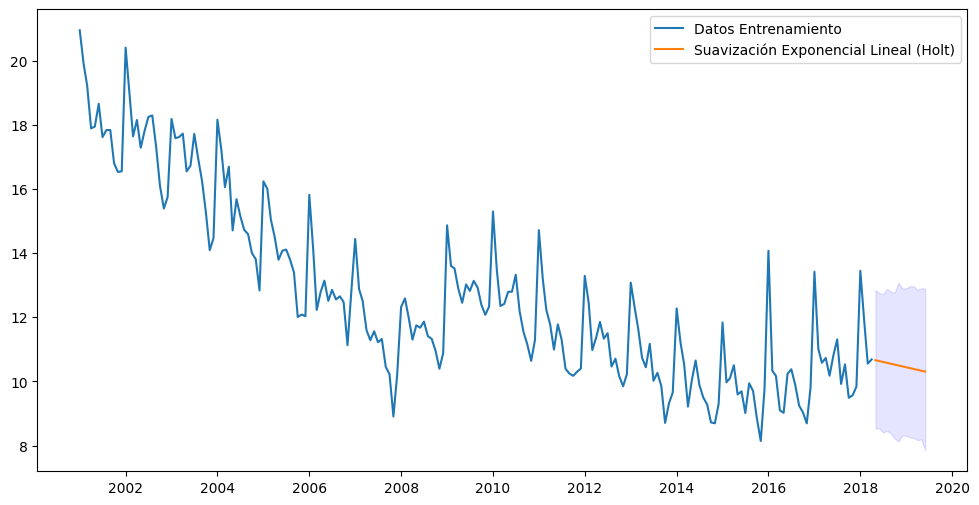

In [24]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

En esta caso el α estimado es 0.17153975893378887 y el β estimado es 1.7153975893378887$^{-5}$. Y el RMSE en la muestra de evaluación es 1.2780044501304348.

In [25]:
print(ets_result.alpha,ets_result.beta)

0.17153909365393913 1.7153909365393913e-05


In [26]:
rmse_holt = np.sqrt(mean_squared_error(test_td,preds_holt['Point_forecast']))
print(rmse_holt)

1.228145801463044


## **4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [27]:
# Build model
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(14)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast   lower_95   upper_95
2018-05-01       10.297371   9.251560  11.343183
2018-06-01       10.674325   9.532337  11.816313
2018-07-01       10.565100   9.334412  11.795788
2018-08-01       10.226589   8.913162  11.540017
2018-09-01        9.946370   8.555100  11.337640
2018-10-01        9.282632   7.817635  10.747628
2018-11-01        8.875136   7.339935  10.410336
2018-12-01        9.376551   7.774206  10.978895
2019-01-01       12.534208  10.867410  14.201006
2019-02-01       11.193066   9.464203  12.921928
2019-03-01       10.434228   8.645441  12.223015
2019-04-01       10.158460   8.311680  12.005240
2019-05-01        9.827778   7.924747  11.730809
2019-06-01       10.204732   8.247068  12.162395


c:\Personal\Sebas\Universidades\ICESI\Maestrias\InteligenciaArtificialAplicada\Aprendizaje Automatico III\Notebooks\env-AA3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


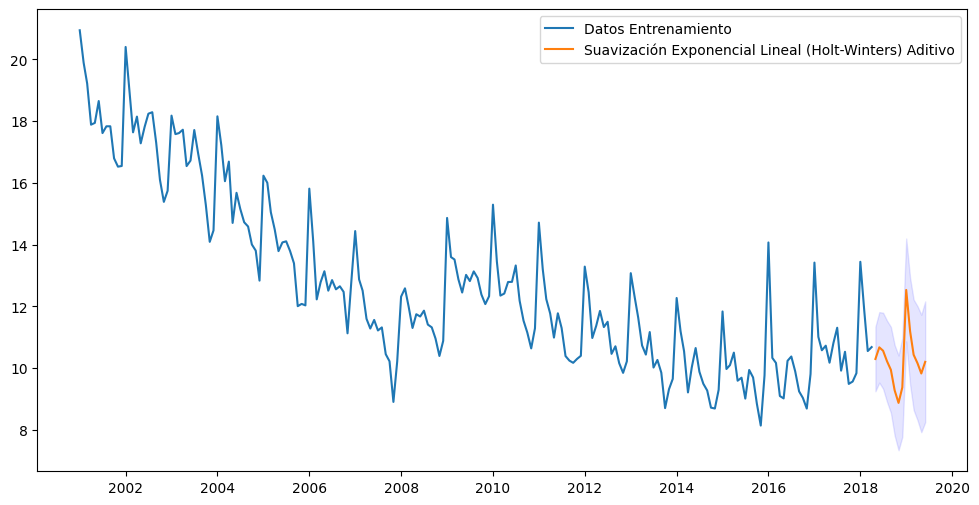

In [28]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [29]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.43857184633310375 4.385718463331038e-05 5.6142815366689624e-05


In [30]:
rmse_hw_add = np.sqrt(mean_squared_error(test_td,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

0.9893610351254504


In [31]:
# Build model.
ets_model = ETSModel(endog=train_td["TD_13ciudades"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(14)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

            Point_forecast   lower_95   upper_95
2018-05-01       10.433036   9.371343  11.593744
2018-06-01       10.981856   9.741102  12.185736
2018-07-01       10.779516   9.591914  12.065256
2018-08-01       10.380956   8.952377  11.769984
2018-09-01       10.300534   8.766052  11.726843
2018-10-01        9.708898   8.260330  11.194776
2018-11-01        9.565507   8.039393  11.127176
2018-12-01       10.265134   8.547454  11.919323
2019-01-01       13.399531  11.336698  15.614739
2019-02-01       11.447407   9.599819  13.272408
2019-03-01       10.843306   8.895966  12.751108
2019-04-01       10.618172   8.618543  12.499653
2019-05-01       10.433036   8.536741  12.343754
2019-06-01       10.981856   8.990343  13.106502


c:\Personal\Sebas\Universidades\ICESI\Maestrias\InteligenciaArtificialAplicada\Aprendizaje Automatico III\Notebooks\env-AA3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


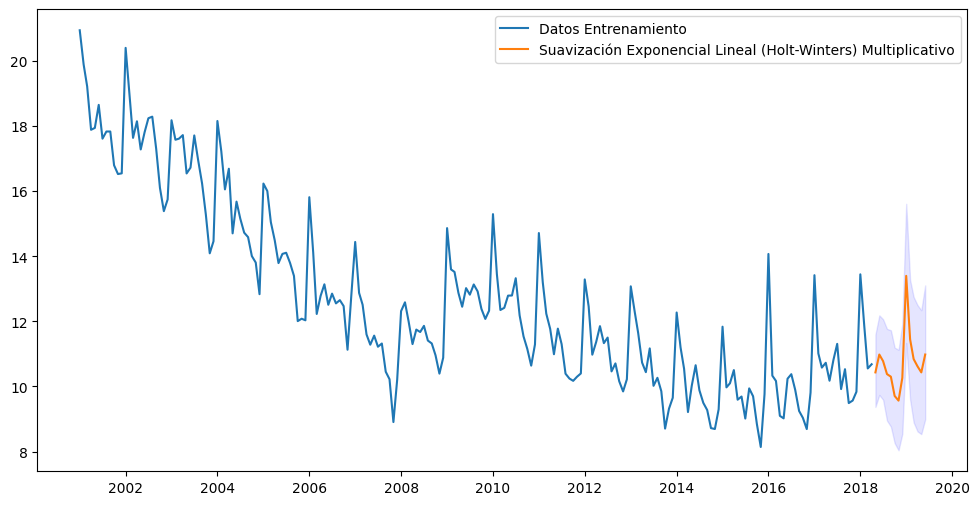

In [32]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [33]:
print(ets_result.alpha,ets_result.gamma)

0.4314982974685176 0.1609708946436222


In [34]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_td,preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

0.601249106131057


## **5. Ejercicio en Clase**

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.